In [1]:
%pip install segmentation_models_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 30.5 MB/s eta 0:00:0000:0100:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=824185b615486f99623a2ce95191ea35a84e19758230d7e47c91f9d1c1d7041b
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=ee96dbbcbddc9fa507b8279f20a1a063c73b9fb916b3a06ffab903b3e5e3ff70
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels
  Attempting uninstall: timm
    Found e

In [97]:
import tensorflow as tf
import ast
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.nn.functional import relu
from torch.utils.data import Dataset
from PIL import Image
from tqdm import tqdm
import segmentation_models_pytorch as smp
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import confusion_matrix
import seaborn as sns
import cv2
from scipy import interpolate

print(tf.__version__)

2.12.0


In [98]:
# checking if gpu is working
device_name = tf.test.gpu_device_name()

if "GPU" not in device_name:
    print("GPU device not found")
    
print('Found GPU at: {}'.format(device_name))

print("GPU", "available (YESS!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

Found GPU at: /device:GPU:0
GPU available (YESS!!!!)


In [174]:
df = pd.read_csv("/kaggle/input/ranzcr-clip-catheter-line-classification/train.csv")
TRAIN_PATH = "/kaggle/input/ranzcr-clip-catheter-line-classification/train"

In [176]:
labels_dict = {
    'CVC - Normal': 1,
    'CVC - Abnormal': 0
}

In [183]:
print("train", df['CVC - Normal'].value_counts())

train CVC - Normal
1    6348
0     876
Name: count, dtype: int64


In [184]:
columns_to_drop = ['ETT - Abnormal', 'ETT - Borderline', 'ETT - Normal', 'NGT - Abnormal', 'NGT - Borderline', 'NGT - Normal',
                  "NGT - Incompletely Imaged", "Swan Ganz Catheter Present", "PatientID", "CVC - Borderline", 'CVC - Abnormal']

df = df.drop(columns=columns_to_drop, axis = 1)

df_0 = df[df["CVC - Normal"] == 0]
df_1 = df[df["CVC - Normal"] == 1]

# Sample 300 rows from each DataFrame
sampled_0 = df_0.sample(n=800, random_state=42)  # Using random_state for reproducibility
sampled_1 = df_1.sample(n=800, random_state=42)

# Concatenate the samples to get a balanced subset
df = pd.concat([sampled_0, sampled_1]).reset_index(drop=True)

test = df.sample(frac=0.15, random_state=42)
df = df.drop(test.index).reset_index(drop=True)
test = test.reset_index(drop=True)
valid = df.sample(frac=0.1, random_state=42)
df = df.drop(valid.index).reset_index(drop=True)
valid = valid.reset_index(drop=True)

In [185]:
# should be all zero
matches_in_test = df['StudyInstanceUID'].isin(test['StudyInstanceUID']).sum()
print("test matches:", matches_in_test)

matches_in_val = df['StudyInstanceUID'].isin(valid['StudyInstanceUID']).sum()
print("valid matches:", matches_in_val)

test matches: 0
valid matches: 0


In [186]:
print("train", df['CVC - Normal'].value_counts())
print("valid", valid['CVC - Normal'].value_counts())
print("test", test['CVC - Normal'].value_counts())

train CVC - Normal
1    668
0    628
Name: count, dtype: int64
valid CVC - Normal
0    79
1    65
Name: count, dtype: int64
test CVC - Normal
0    93
1    67
Name: count, dtype: int64


In [187]:
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

In [188]:
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.file_names = dataframe["StudyInstanceUID"].values
        self.labels = dataframe['CVC - Normal'].values

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        image_path = f"{TRAIN_PATH}/{file_name}.jpg"
        
        image = cv2.imread(image_path)
        image = cv2.resize(image, (256,256))
        image = np.asarray(image, dtype=np.float32) / 255.0
        image = (image - imagenet_mean) / imagenet_std
    
        labels = torch.tensor(self.labels[idx]).float()
        return image, torch.tensor(labels)

In [189]:
class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['StudyInstanceUID'].values
        self.labels = df['CVC - Normal'].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        image_path = f"{TRAIN_PATH}/{file_name}.jpg"
        
        image = cv2.imread(image_path)
        image = cv2.resize(image, (256,256))
        image = np.asarray(image, dtype=np.float32) / 255.0
        image = (image - imagenet_mean) / imagenet_std
        
        labels = torch.tensor(self.labels[idx]).float()
        return image, torch.tensor(labels)

In [190]:
train_dataset = CustomDataset(df)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)

valid_dataset = CustomDataset(valid)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=8, shuffle=True)

test_dataset = TestDataset(test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=True)

In [191]:
img_test = train_dataset[2][0]
img_test = img_test.astype(np.uint8)
img_test.shape

(256, 256, 3)

In [192]:
device = "cuda"

In [193]:
model = smp.UnetPlusPlus("timm-regnetx_002", encoder_weights = "imagenet", classes=3, in_channels=3, aux_params = dict(classes = 1, dropout=0.1, pooling = "max"))
model = model.to(device)

In [194]:
optim = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = torch.nn.BCEWithLogitsLoss()
sigmoid = torch.nn.Sigmoid()

In [195]:
def train(model, trainloader, epochs: int, valloader):
    model.train()
    train_loss_list = []
    train_accuracy_list = []
    val_loss_list = []
    val_accuracy_list = []


    for epoch in tqdm(range(epochs), position=0, leave=True, desc="Epochs"):
        total_samples = 0
        epoch_loss = 0
        num_matches = 0

        for data in trainloader:
            inputs, labels = data
            inputs = inputs.unsqueeze(1) # adds channel dimension to work with unet input
            inputs = inputs.permute(0, 4, 2, 3, 1)
            inputs = inputs.squeeze(-1)  # this removes the unnecessary channel dimension
            inputs = inputs.to(device)
            inputs = inputs.to(torch.float32)
            labels = labels.to(device)

            optim.zero_grad()
            _, outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))

            loss.backward()
            optim.step()

            labels = labels.long()
            probabilities = sigmoid(outputs)
#             print("labels", labels)
            threshold = 0.50
            predicted = (probabilities > threshold).float()
            predicted = predicted.view(-1,1)
            predicted = predicted.squeeze()
#             print("preds", predicted)
            matching_indices = (labels == predicted)
#             print("matching_indices", matching_indices)
            num_matches += matching_indices.sum().item()
#             print("num_matches", num_matches)
            total_samples += labels.size(0)
#             print("total_samples", total_samples)

            epoch_loss += loss.item()

        train_accuracy = num_matches / total_samples
        train_accuracy_list.append(train_accuracy)
        train_loss_list.append(epoch_loss)
#         print("Training - epoch num", epoch + 1, "done!")
        
         # Validation
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            val_loss = 0
            val_matches = 0
            val_samples = 0
            
            for data in valloader:
                inputs, labels = data
                inputs = inputs.unsqueeze(1)  # adds channel dimension to work with unet input
                inputs = inputs.permute(0, 4, 2, 3, 1)
                inputs = inputs.squeeze(-1)  # this removes the unnecessary channel dimension
                inputs = inputs.to(device)
                inputs = inputs.to(torch.float32)
                labels = labels.to(device)
                
                _, outputs = model(inputs)
                loss = criterion(outputs, labels.unsqueeze(1))
                
                labels = labels.long()
#                 print("labels", labels)
                probabilities = sigmoid(outputs)
                threshold = 0.50
                predicted = (probabilities > threshold).float()
                predicted = predicted.view(-1,1)
                predicted = predicted.squeeze()
                matching_indices = (labels == predicted)
                
                val_matches += matching_indices.sum().item()
                val_samples += labels.size(0)
                val_loss += loss.item()

            val_accuracy = val_matches / val_samples
            val_accuracy_list.append(val_accuracy)
            val_loss_list.append(val_loss)
            model.train()


    return train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list

In [196]:
epochs = 25

In [197]:
train_loss, train_acc, val_loss, val_acc = train(model, train_loader, epochs, valid_loader)

Epochs: 100%|██████████| 15/15 [31:40<00:00, 126.71s/it]


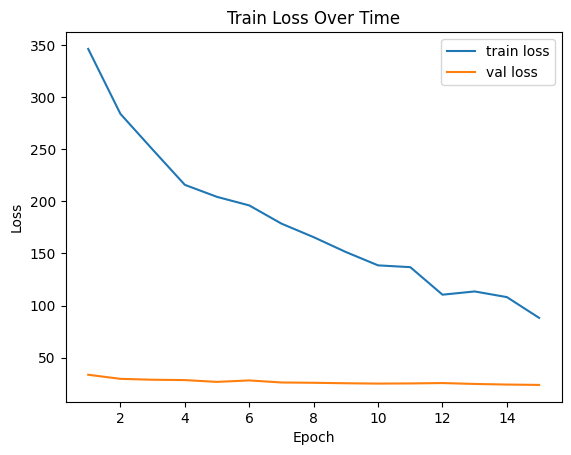

In [198]:
plt.plot(range(1,epochs+1), train_loss, label="train loss")
plt.plot(range(1,epochs+1), val_loss, label="val loss")
plt.title("Train Loss Over Time")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend();

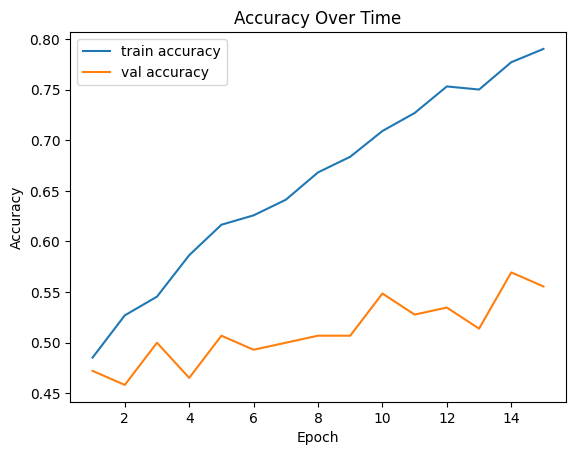

In [199]:
plt.plot(range(1,epochs+1), train_acc, label = "train accuracy")
plt.plot(range(1,epochs+1), val_acc, label = "val accuracy")
plt.title("Accuracy Over Time")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend();

In [200]:
print("train_loss", train_loss)
print("train_acc", train_acc)
print("valid_loss", val_loss)
print("valid_acc", val_acc)

train_loss [346.33036836981773, 284.0050706267357, 249.7438561320305, 215.8805836532265, 204.31710989028215, 196.12348599731922, 178.63697993010283, 165.64326747879386, 151.39350274577737, 138.5758329052478, 136.85847415588796, 110.42876398935914, 113.54323339369148, 108.0979014635086, 88.19063187390566]
train_acc [0.4853395061728395, 0.5270061728395061, 0.5455246913580247, 0.5864197530864198, 0.6165123456790124, 0.6257716049382716, 0.6412037037037037, 0.6682098765432098, 0.683641975308642, 0.7091049382716049, 0.7268518518518519, 0.7530864197530864, 0.75, 0.7770061728395061, 0.7901234567901234]
valid_loss [33.57888379693031, 29.65739607810974, 28.79741370677948, 28.458407163619995, 26.738714039325714, 28.130456626415253, 26.165630102157593, 25.873921930789948, 25.421008735895157, 25.090269565582275, 25.257500171661377, 25.61771920323372, 24.75422403216362, 24.179348707199097, 23.821456253528595]
valid_acc [0.4722222222222222, 0.4583333333333333, 0.5, 0.4652777777777778, 0.5069444444444

In [168]:
torch.save(model.state_dict(), 'UNet_model.pth')

In [201]:
def evaluate(model, test_loader):
    """
    Evaluates the model on the given validation loader.

    Args:
    - model (torch.nn.Module): The model to evaluate.
    - val_loader (torch.utils.data.DataLoader): DataLoader for validation data.

    Returns:
    - Tuple[float, float]: Returns validation loss and accuracy.
    """

    model.eval()

    num_matches = 0
    total_samples = 0
    labels_list = []
    pred_list = []

    with torch.no_grad():
        for data in tqdm(test_loader):

            inputs, labels = data
            inputs = inputs.unsqueeze(1) # adds channel dimension to work with unet input
            inputs = inputs.permute(0, 4, 2, 3, 1)
            inputs = inputs.squeeze(-1)  # this removes the unnecessary channel dimension
            inputs = inputs.to(device)  # moved inputs to device
            inputs = inputs.to(torch.float32)
            labels = labels.to(device)  # moved labels to device
            print("labels", labels)
            _, outputs = model(inputs)
#             print("labels", labels)

            labels = labels.long()
            threshold = 0.50
            probabilities = sigmoid(outputs)
            print(probabilities)
            predicted = (probabilities > threshold).float()
            predicted = predicted.view(-1,1)
            predicted = predicted.squeeze()
            labels_list.append(labels)
            pred_list.append(predicted)
            matching_indices = (labels == predicted)
            num_matches += matching_indices.sum().item()
            total_samples += labels.size(0)

    accuracy = num_matches / total_samples

    return accuracy, labels_list, pred_list

In [202]:
test_acc, labels, preds = evaluate(model, test_loader)

  5%|▌         | 1/20 [00:00<00:15,  1.25it/s]

labels tensor([1., 1., 1., 1., 1., 0., 1., 0.], device='cuda:1')
tensor([[0.6513],
        [0.2073],
        [0.0413],
        [0.9488],
        [0.9543],
        [0.8230],
        [0.1892],
        [0.6299]], device='cuda:1')


 10%|█         | 2/20 [00:01<00:14,  1.25it/s]

labels tensor([1., 0., 1., 0., 1., 0., 1., 0.], device='cuda:1')
tensor([[0.0235],
        [0.0101],
        [0.0647],
        [0.3627],
        [0.0964],
        [0.5715],
        [0.6840],
        [0.1123]], device='cuda:1')


 15%|█▌        | 3/20 [00:02<00:13,  1.24it/s]

labels tensor([0., 0., 0., 1., 1., 1., 0., 0.], device='cuda:1')
tensor([[0.0255],
        [0.5046],
        [0.9959],
        [0.8999],
        [0.6808],
        [0.8992],
        [0.9647],
        [0.9683]], device='cuda:1')


 20%|██        | 4/20 [00:03<00:13,  1.22it/s]

labels tensor([0., 1., 0., 1., 1., 0., 1., 0.], device='cuda:1')
tensor([[0.3882],
        [0.9524],
        [0.1307],
        [0.8798],
        [0.9872],
        [0.5094],
        [0.9787],
        [0.0517]], device='cuda:1')


 25%|██▌       | 5/20 [00:04<00:11,  1.25it/s]

labels tensor([0., 1., 0., 1., 1., 0., 0., 0.], device='cuda:1')
tensor([[9.7954e-01],
        [1.7038e-01],
        [9.6151e-01],
        [1.6138e-02],
        [8.0738e-02],
        [1.1448e-02],
        [2.1820e-04],
        [8.8362e-01]], device='cuda:1')


 30%|███       | 6/20 [00:04<00:11,  1.22it/s]

labels tensor([1., 0., 0., 0., 0., 0., 1., 0.], device='cuda:1')
tensor([[0.1245],
        [0.0372],
        [0.0033],
        [0.9811],
        [0.6707],
        [0.9115],
        [0.8515],
        [0.8844]], device='cuda:1')


 35%|███▌      | 7/20 [00:05<00:10,  1.23it/s]

labels tensor([0., 1., 1., 0., 0., 1., 0., 1.], device='cuda:1')
tensor([[0.1285],
        [0.6541],
        [0.3492],
        [0.7245],
        [0.3638],
        [0.0705],
        [0.9506],
        [0.8893]], device='cuda:1')


 40%|████      | 8/20 [00:06<00:09,  1.20it/s]

labels tensor([1., 0., 0., 1., 0., 0., 1., 1.], device='cuda:1')
tensor([[0.7296],
        [0.2933],
        [0.6490],
        [0.9006],
        [0.0694],
        [0.5520],
        [0.6915],
        [0.2772]], device='cuda:1')


 45%|████▌     | 9/20 [00:07<00:09,  1.21it/s]

labels tensor([0., 0., 0., 1., 0., 0., 0., 0.], device='cuda:1')
tensor([[0.5511],
        [0.9174],
        [0.9587],
        [0.7697],
        [0.9435],
        [0.0715],
        [0.3845],
        [0.9927]], device='cuda:1')


 50%|█████     | 10/20 [00:08<00:08,  1.22it/s]

labels tensor([0., 1., 0., 0., 0., 0., 1., 0.], device='cuda:1')
tensor([[0.9846],
        [0.2533],
        [0.9942],
        [0.0494],
        [0.8036],
        [0.9365],
        [0.8515],
        [0.1183]], device='cuda:1')


 55%|█████▌    | 11/20 [00:09<00:07,  1.20it/s]

labels tensor([0., 0., 1., 0., 1., 0., 1., 1.], device='cuda:1')
tensor([[0.3887],
        [0.0058],
        [0.8107],
        [0.0327],
        [0.9691],
        [0.8946],
        [0.9835],
        [0.0425]], device='cuda:1')


 60%|██████    | 12/20 [00:09<00:06,  1.24it/s]

labels tensor([0., 1., 1., 0., 0., 0., 0., 0.], device='cuda:1')
tensor([[0.9733],
        [0.9848],
        [0.8584],
        [0.0258],
        [0.1499],
        [0.5356],
        [0.0174],
        [0.9861]], device='cuda:1')


 65%|██████▌   | 13/20 [00:10<00:05,  1.27it/s]

labels tensor([0., 1., 1., 1., 0., 0., 1., 0.], device='cuda:1')
tensor([[0.8914],
        [0.0014],
        [0.0083],
        [0.9202],
        [0.6269],
        [0.9950],
        [0.7431],
        [0.5700]], device='cuda:1')


 70%|███████   | 14/20 [00:11<00:04,  1.23it/s]

labels tensor([1., 1., 0., 0., 0., 0., 0., 0.], device='cuda:1')
tensor([[0.0271],
        [0.0217],
        [0.9031],
        [0.8991],
        [0.9799],
        [0.2220],
        [0.4657],
        [0.0907]], device='cuda:1')


 75%|███████▌  | 15/20 [00:12<00:03,  1.26it/s]

labels tensor([0., 1., 1., 0., 1., 0., 0., 1.], device='cuda:1')
tensor([[0.9143],
        [0.0156],
        [0.7871],
        [0.9996],
        [0.7996],
        [0.0075],
        [0.2383],
        [0.5681]], device='cuda:1')


 80%|████████  | 16/20 [00:12<00:03,  1.23it/s]

labels tensor([1., 1., 1., 0., 1., 1., 1., 1.], device='cuda:1')
tensor([[0.9817],
        [0.5806],
        [0.0930],
        [0.5901],
        [0.9991],
        [0.9521],
        [0.9795],
        [0.9805]], device='cuda:1')


 85%|████████▌ | 17/20 [00:13<00:02,  1.25it/s]

labels tensor([0., 0., 0., 0., 0., 1., 0., 0.], device='cuda:1')
tensor([[8.6720e-02],
        [9.1134e-02],
        [4.3651e-01],
        [7.3464e-01],
        [2.5336e-04],
        [9.5775e-02],
        [5.8916e-01],
        [1.5187e-02]], device='cuda:1')


 90%|█████████ | 18/20 [00:14<00:01,  1.27it/s]

labels tensor([1., 0., 0., 0., 0., 0., 1., 0.], device='cuda:1')
tensor([[0.0014],
        [0.8990],
        [0.3711],
        [0.8370],
        [0.4500],
        [0.9296],
        [0.8780],
        [0.4698]], device='cuda:1')


 95%|█████████▌| 19/20 [00:15<00:00,  1.25it/s]

labels tensor([1., 0., 0., 1., 1., 1., 0., 0.], device='cuda:1')
tensor([[0.5958],
        [0.9669],
        [0.2048],
        [0.4471],
        [0.0043],
        [0.4302],
        [0.6117],
        [0.9837]], device='cuda:1')


100%|██████████| 20/20 [00:16<00:00,  1.24it/s]

labels tensor([0., 0., 1., 0., 1., 1., 0., 1.], device='cuda:1')
tensor([[0.3920],
        [0.0245],
        [0.0133],
        [0.8684],
        [0.1760],
        [0.0952],
        [0.6182],
        [0.9493]], device='cuda:1')


In [203]:
test_acc

0.49375

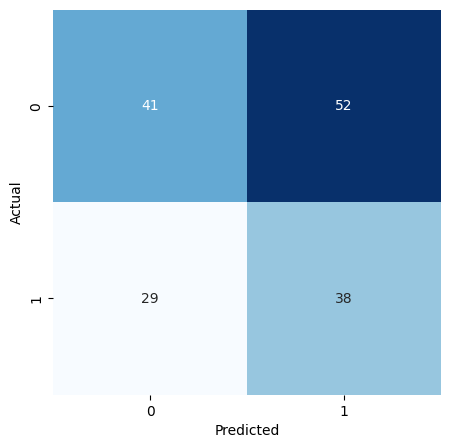

In [204]:
preds_tensor = torch.cat(preds).cpu().numpy()
labels_tensor = torch.cat(labels).cpu().numpy()

# Compute the confusion matrix
cm = confusion_matrix(labels_tensor, preds_tensor)

# Visualize the confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()